In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')



# 1. Creating a dataset

For this labo, we will transform an image into a dataset including the coordinates of the pixels and their RGB values.
First, we load in a sample image of a flower from sklearn.

uint8


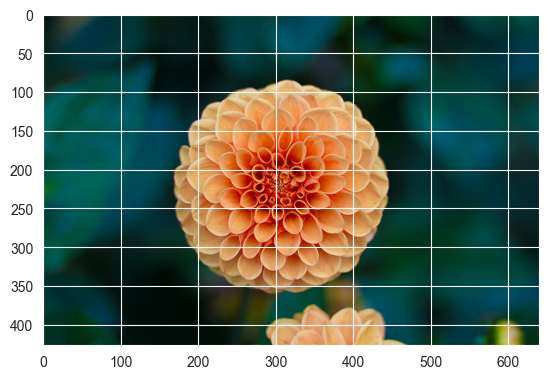

In [3]:
from sklearn.datasets import load_sample_image
colors = 'rgbymc'
flower = load_sample_image('flower.jpg')
print(flower.dtype)
plt.imshow(flower)

Then, we create a dataset from this image.

In [4]:
# first, initiate an array with all zeros, with as number of observations the number of pixels, and as numbers of columns 5 (3 RGB-values + x- an y- coordinates of the pixel)
# However, to speed up training, we will only use 1/4th of the pixel (so we divide by 4 and only store every second row/column)
X = np.zeros((int(flower.shape[0]*flower.shape[1]/4), flower.shape[2]+2))
cc=0

# Now, we store the information from the image in the empty array
for i in range(0, flower.shape[0]-1, 2):
  for j in range(0, flower.shape[1]-1, 2):
    X [cc][0] = i/2  # in column 0, we store the x-coordinate of the picture
    X [cc][1] = j/2  # in column 1, we store the y-coordinate of the picture
    for k in range(flower.shape[2]):
      X [cc][2+k] = flower[i, j, k] # in columns 2 to 4, we store the RGB-values of the pixel. (and we immediately standardize by dividing by 255)
    cc += 1

Next, we try to plot our new dataset.

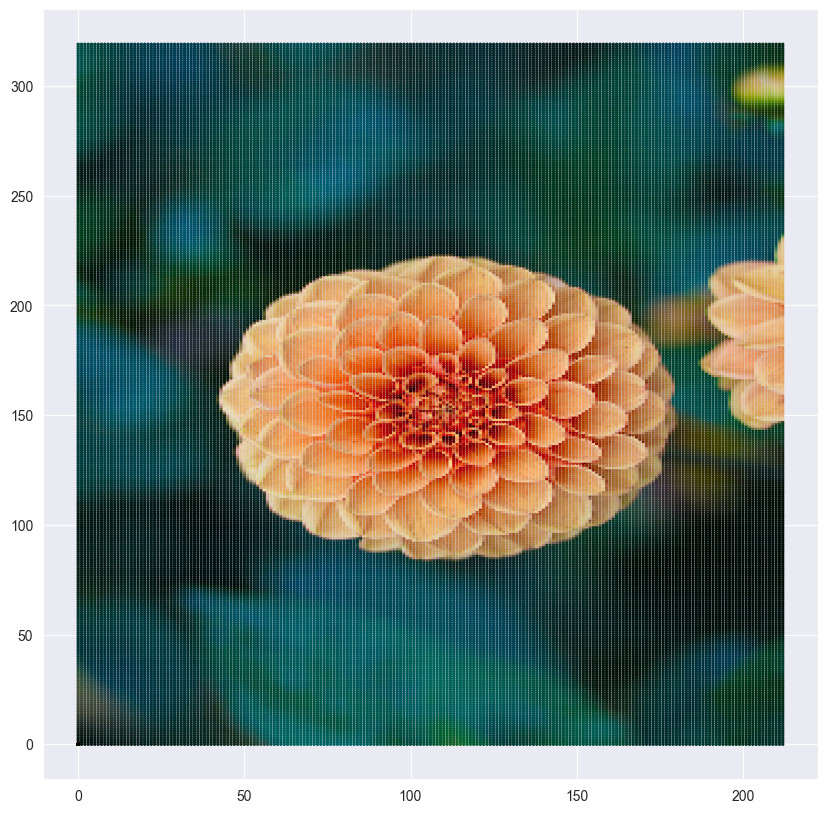

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(X [:, 0], X [:, 1], c=X [:, 2:]/255, s=2)

We can still clearly recognize the flower.

# 2. K-means using sklearn

Now, we will try to cluster the different pixels in our image. We start with k-means.

## 2.1 Determining number of clusters

1. Try the kmeans algorithm for a number of possible clusters: 1 to 15 and calculate the SSE for each of them.
2. Plot the results

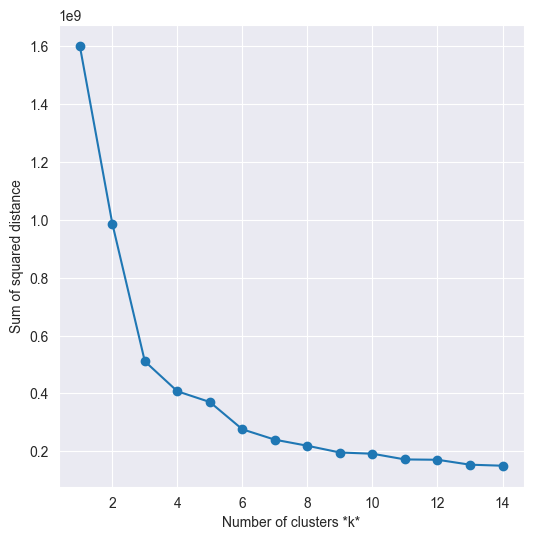

In [6]:
from sklearn.cluster import KMeans
sse = []
list_k = list(range(1,15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

After 3 clusters, the decline in SSE slows down, so I will try 3 clusters.

## 2.2 Performing k-means clustering
1. Refit the model with the 3 clusters

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0)
# predict the labels of each point
y_kmeans = kmeans.fit_predict(X)
print(y_kmeans)
y_kmeans.shape

[0 0 0 ... 0 0 0]


(68320,)

 2. Plot the results (the code is already given)

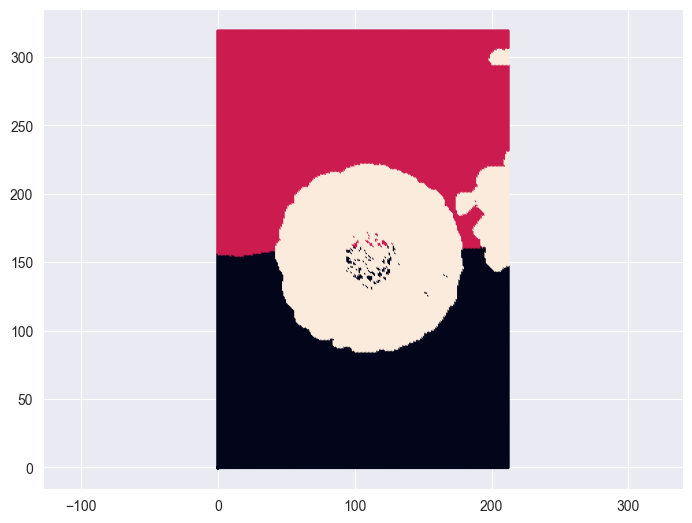

In [8]:
# plot results
fig_kmeans = plt.figure()
ax_kmeans = fig_kmeans.add_axes([0,0,1,1])
ax_kmeans.axis('equal')
plt.scatter(X[:, 0], X[:, 1], c=np.array(y_kmeans),s=2);


We see the flower (=one cluster) and it is also clear that the algorithm used the position of the pixels to differntiatie between the other 2 clusters.
Now, let's plot the same results, but use the color of the cluster centers.

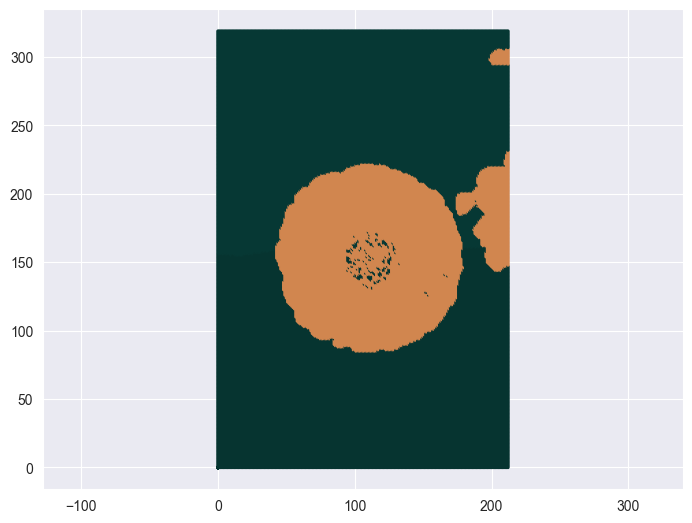

In [9]:
# plot results
fig_kmeans = plt.figure()
ax_kmeans = fig_kmeans.add_axes([0,0,1,1])
ax_kmeans.axis('equal')
ccent = kmeans.cluster_centers_[:,2:5]/255.0     # extracts the color of the cluster centers (and standardizes them)
cols = [ccent[l,:] for l in y_kmeans]            # assign the correct color for each pixel
plt.scatter(X[:, 0], X[:, 1], c=cols,s=2);

3. We can clearly see our flower now. But I'm wondering if kmeans could be able to reproduce our picture. Let's try some larger k's: 5,15,30 and 60

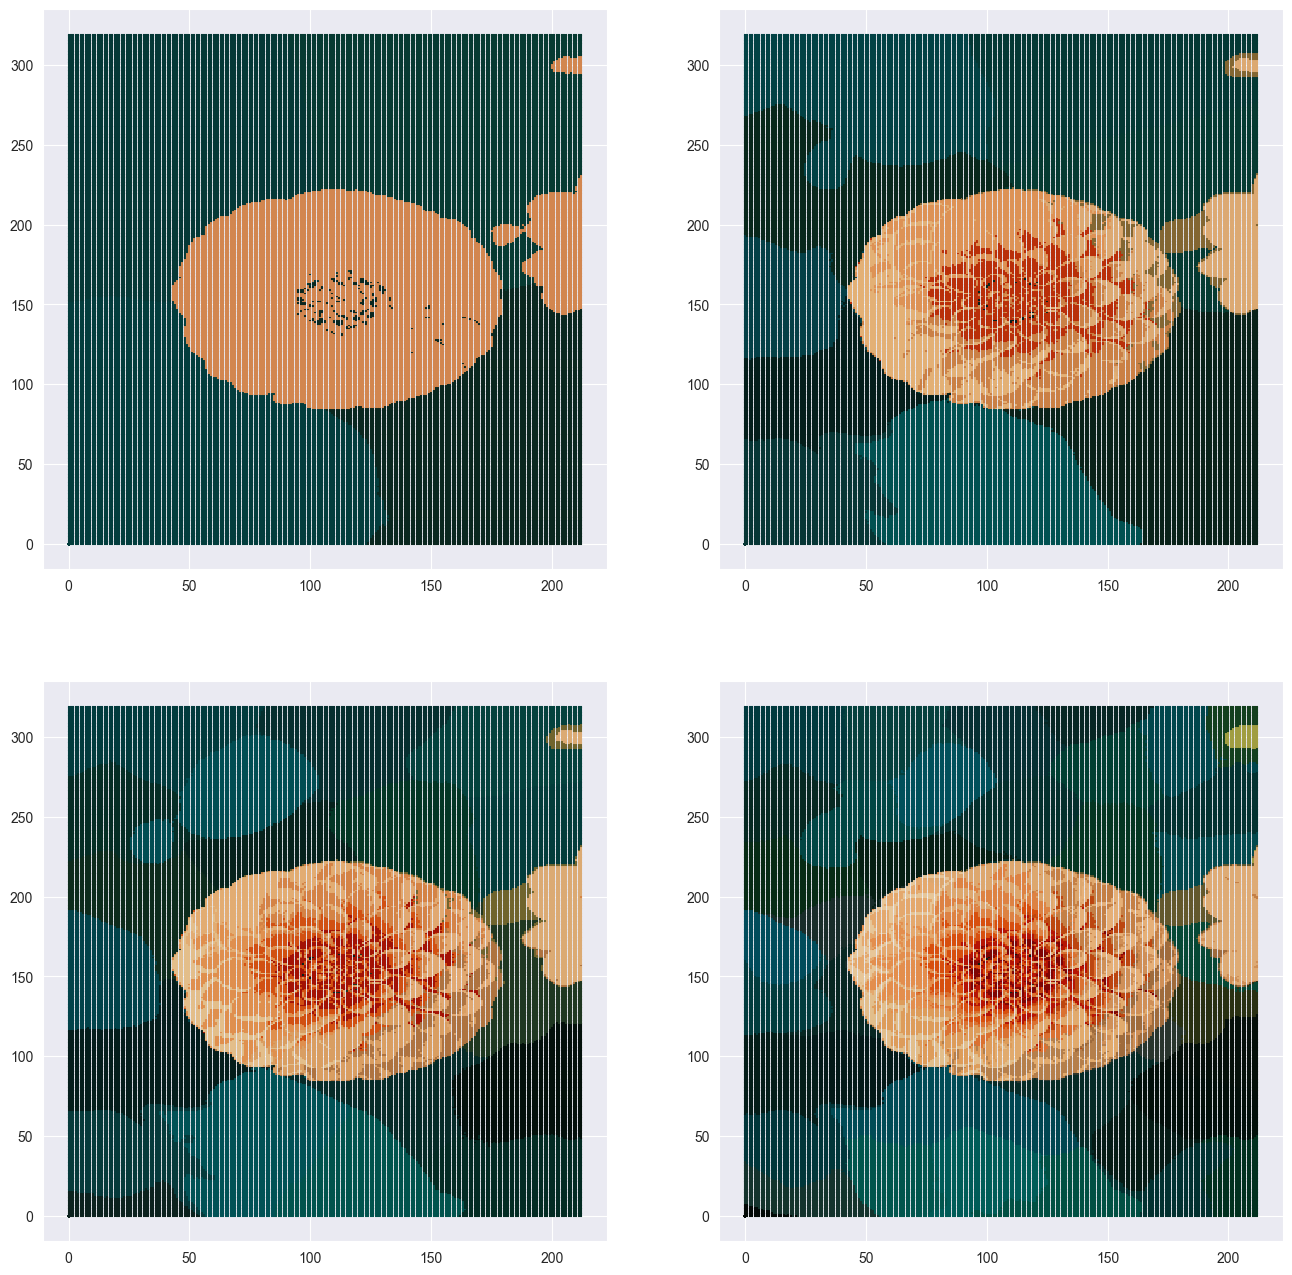

In [10]:
ks = [5,15,30,60]
fig = plt.figure(figsize=(16,16))
for i, k in enumerate(ks):
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    ccent = km.cluster_centers_[:,2:5]/255.0
    lcols = [ccent[l,:] for l in labels]
    ax = fig.add_subplot(2,2,i+1)
    plt.scatter(X[:,0], X[:,1], c=lcols, s=2, marker='+')

With a large number of clusters, kmeans is able to recreate the image.


# 3. Gaussian mixture modeling

Let's try the same thing for GMM

1. Fit the model with 3 components and plot the result.

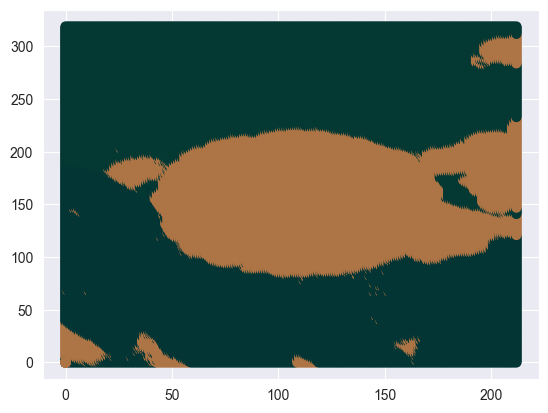

In [11]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
ccent = gmm.means_[:,2:5]/255.0     # extracts the color of the cluster centers (and standardizes them)
cols = [ccent[l,:] for l in labels]            # assign the correct color for each pixel
plt.scatter(X[:,0], X[:,1], c=cols, s=40, cmap='autumn')

2.  Let's try some larger number of components: 5,15,30 and 60

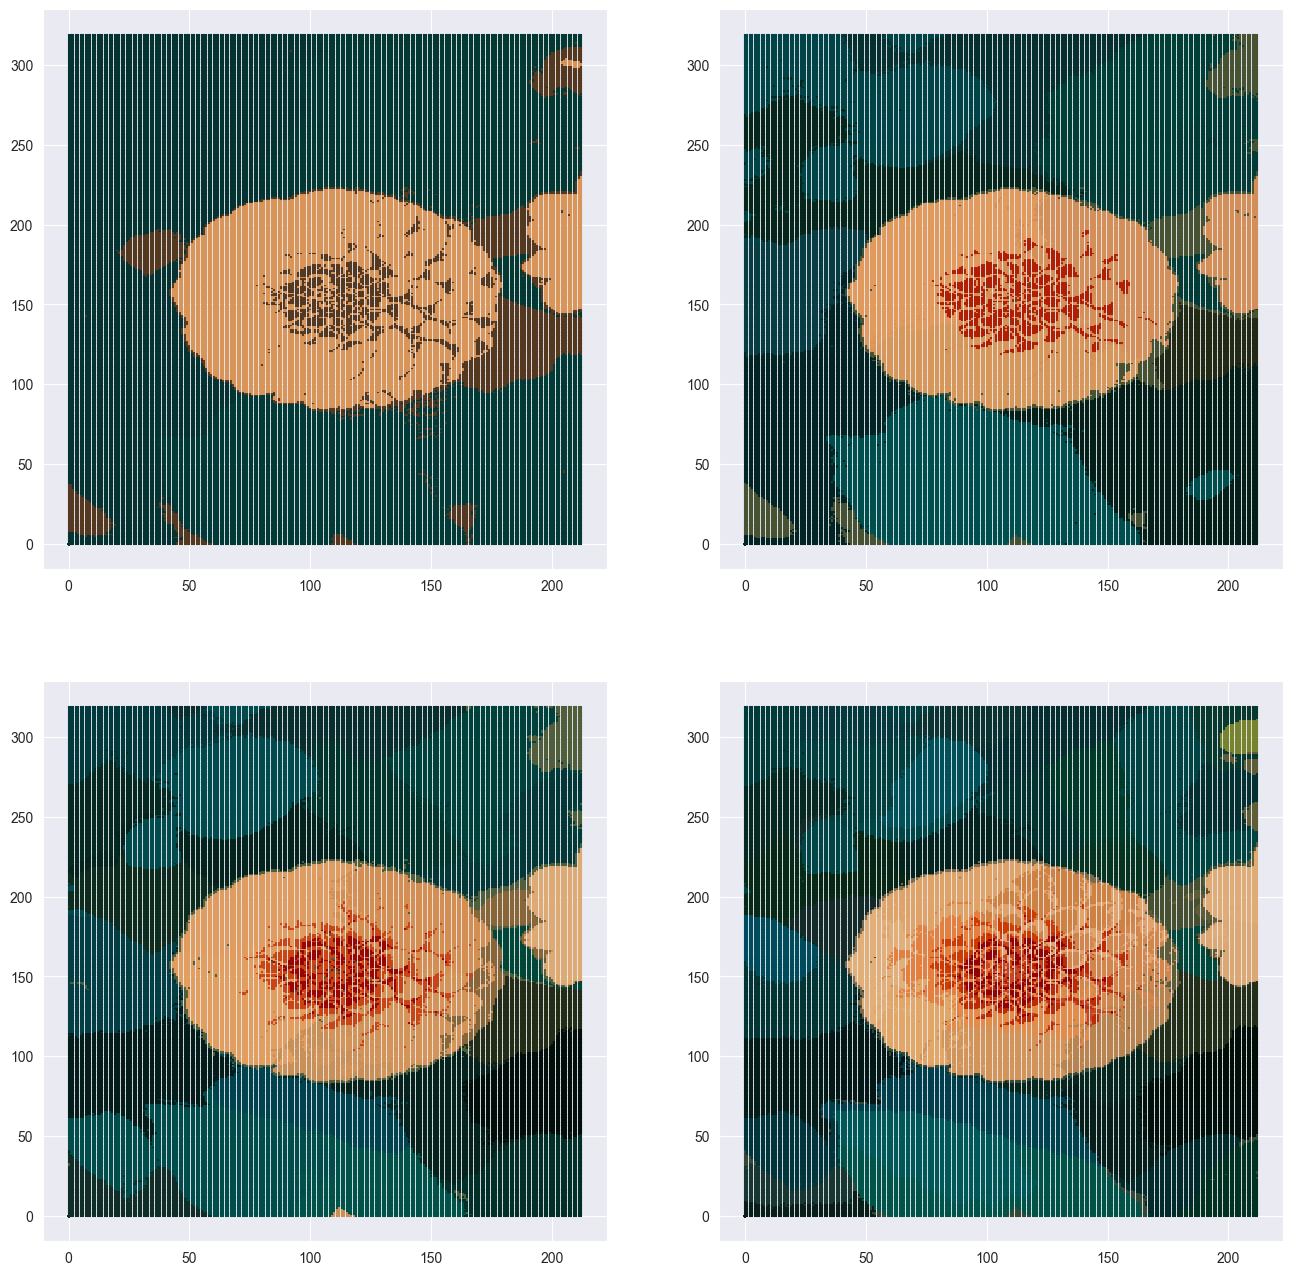

In [12]:
ks = [5,15,30,60]
fig = plt.figure(figsize=(16,16))
for i, k in enumerate(ks):
  gmm = mixture.GaussianMixture(k)
  labels = gmm.fit_predict(X)
  ccent = gmm.means_[:,2:5]/255.0
  lcols = [ccent[l,:] for l in labels]
  ax = fig.add_subplot(2,2,i+1)
  plt.scatter(X[:,0], X[:,1], c=lcols, s=2, marker='+')

Kmeans seems to perform better in this case.

# 4. Hierarchical clustering
We will not perform hierarchical clustering on this image (it runs way too long).

# 5. Density based clustering

1. Make a k-distance plot. Choose the number of neighbors based on the rule of thumbs seen in class.

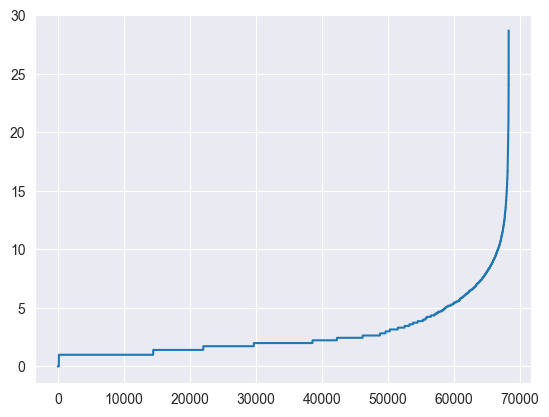

In [13]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=2*5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)



2. Perform a dbscan with epsilon = 10 

85


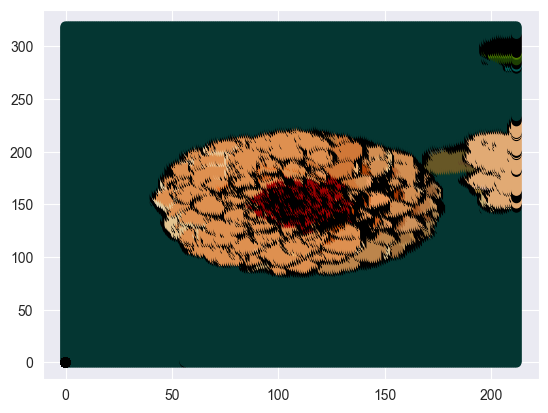

In [14]:
import pandas as pd
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=10, min_samples=10)
labels = dbs.fit_predict(X)
unq = len(np.unique(labels))
ccent = [None]*unq
for i in range(unq) :
    points_of_cluster = pd.DataFrame(X[labels==i,2:5]/255)
    ccent[i] =  np.array(points_of_cluster.mean(axis=0) )
ccent = np.array(ccent)    
lcols = [ccent[l,:] for l in labels]    
plt.scatter(X[:,0], X[:,1], c=lcols, s=40)
print(unq)

We can see that dbscan focusses more on the flower itself and tends to ignore the background.